### Plot and compare Eulerian and Lagrangian binned average covariance of the demodulated velocity signal

In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im
import scipy.optimize as opt

#from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
#import mitequinox.sigp as sp



In [3]:
#Load data
path = '/Users/zcaspar/codes/mit4320/'
dsL = xr.open_dataset(path+'binned_Lcov_dl2.nc') # Lagrangian SSU, 2° bins
dsE = xr.open_dataset(path+'binned_Ecov_dl2.nc') # Eulerian SSU, 2° bins

dsL_vv = xr.open_dataset(path+'binned_Lcov_vv.nc') # Lagrangian SSV, 2° bins

In [4]:
#Mean field
dsL_stats = xr.open_zarr(path+'L_dl1.0_stats.zarr')

In [5]:
# Subsampling Lagrangian data to  match Eulerian dataset
dsL = dsL.isel(lags=slice(0,None,3)).sel(lon_bins=slice(-180,180),lat_bins=slice(-60,60))

In [6]:
# Area of interest
bbox_cal = [-125,35] #california
bbox_med = [4,40] # mediterranean sea
bbox_nwa = [115,-15] # North-west Australia
bbox_nea = [160,-15] # North-west Australia
bbox_swa = [120,-40] # South-west Australia
#bbox_neh = [-160, 35] # North-east Hawaii
bbox_eq = [-125,0] #equator

In [8]:
dsE = dsE.where(dsE.rr!=0) # change 0 to nan (corresponding to land)

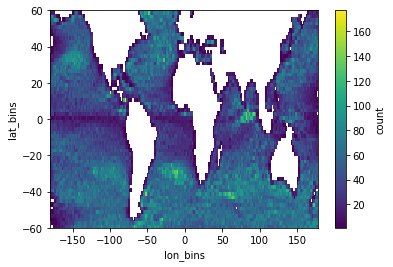

In [23]:
dsL['count'].where(dsL['count']>0).plot()

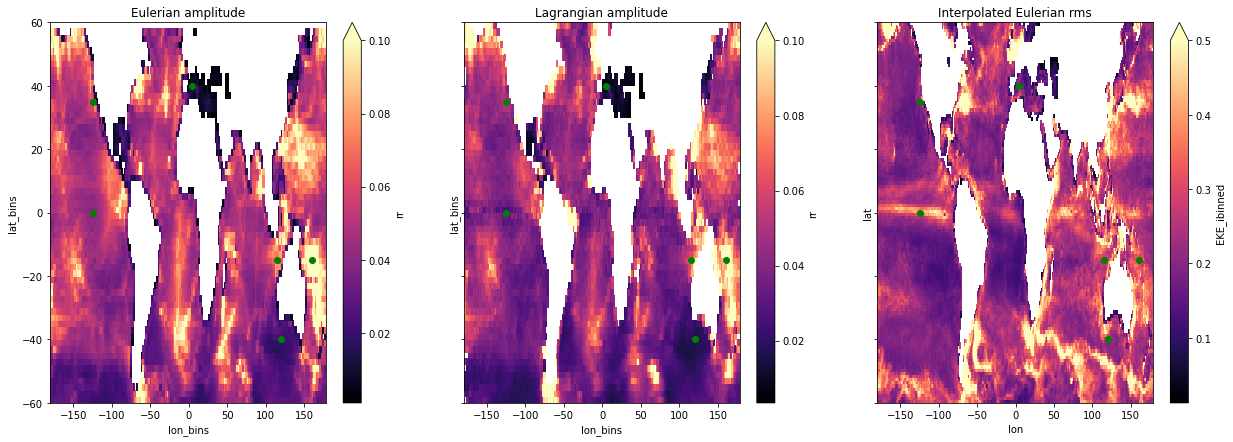

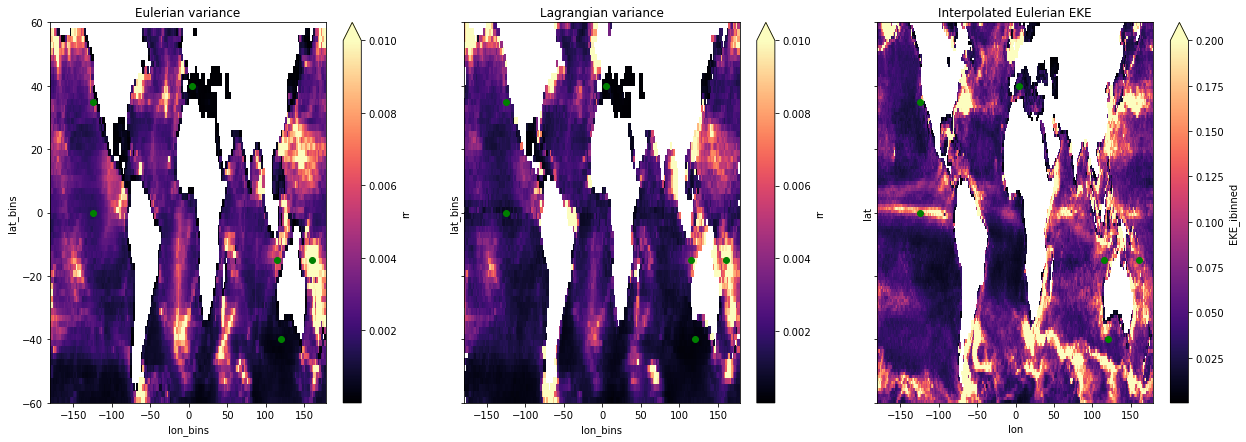

In [13]:
%matplotlib inline
cmap = 'magma'
fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
np.sqrt(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.1,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian amplitude')
np.sqrt(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.1,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian amplitude')
np.sqrt(dsL_stats['EKE_ibinned']).sel(lat=slice(-60,60)).plot(y='lat',vmax=0.5,ax=axs[2],cmap=cmap)
axs[2].set_title('Interpolated Eulerian rms')
for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
    axs[2].scatter(bbox[0],bbox[1],c='g')
#plt.show()

fig,axs = plt.subplots(1,3,figsize=(21,7),sharey=True)
(dsE.isel(lags=0).rr).plot(ax=axs[0],vmax=0.01,cmap=cmap,y='lat_bins')
axs[0].set_title('Eulerian variance')
(dsL.isel(lags=0).rr).plot(ax=axs[1],vmax=0.01,cmap=cmap,y='lat_bins')
axs[1].set_title('Lagrangian variance')
dsL_stats['EKE_ibinned'].sel(lat=slice(-60,60)).plot(y='lat',vmax=0.2,ax=axs[2],cmap=cmap)
axs[2].set_title('Interpolated Eulerian EKE')
for bbox in [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]:
    axs[0].scatter(bbox[0],bbox[1],c='g')
    axs[1].scatter(bbox[0],bbox[1],c='g')
    axs[2].scatter(bbox[0],bbox[1],c='g')
#plt.show()

#### Comments : 
Green points correpond to area of interest defined in previous cell.

Largest discrepancies seem to be near coastal area (even after removing area where depth is smaller than 500m)

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)
/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


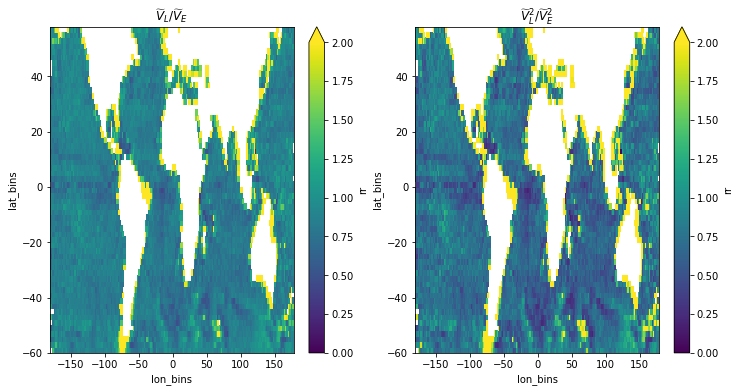

In [24]:
cmap='viridis'
fig,axs = plt.subplots(1,2,figsize=(12,6))
(np.sqrt(dsL.isel(lags=0).rr)/np.sqrt(dsE.isel(lags=0).rr)).plot(cmap=cmap,vmax=2,vmin=0,y='lat_bins',ax=axs[0])
axs[0].set_title(r'$\widetilde{V}_L/\widetilde{V}_E$')
((dsL.isel(lags=0).rr)/(dsE.isel(lags=0).rr)).plot(cmap=cmap,vmax=2,y='lat_bins',vmin=0,ax=axs[1])
axs[1].set_title(r'$\widetilde{V}_L^2/\widetilde{V}_E^2$');

Comments:

1) Lagrangian larger in "coastal" area and in some parts of the Southern ocean

2) Eulerian larger in some other parts of the Southern ocean and near the equator

In [42]:
ratio = dsL.isel(lags=0).rr/dsE.isel(lags=0).rr

/opt/anaconda3/envs/croco/lib/python3.7/site-packages/xarray/core/alignment.py:304: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  index = joiner(matching_indexes)


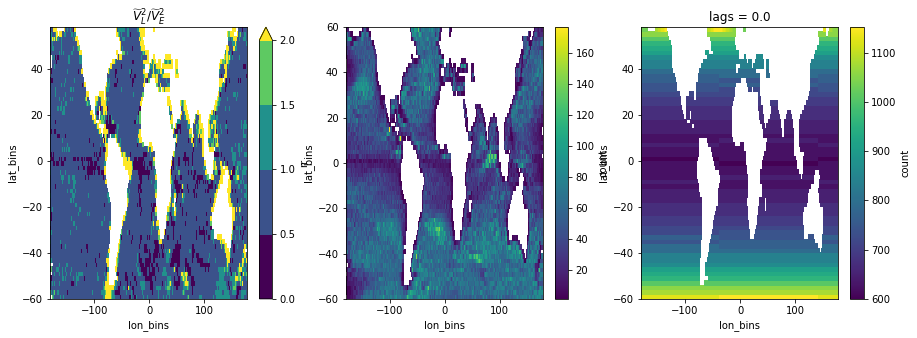

In [56]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ratio.plot(vmax=2,levels=[0,0.5,1,1.5,2],ax=axs[0])
axs[0].set_title(r'$\widetilde{V}_L^2/\widetilde{V}_E^2$')
dsL['count'].where(dsL['count']>0).plot(ax=axs[1])
dsE['count'].where(dsE['count']>0).isel(lags=0).plot(ax=axs[2],y='lat_bins')

Comments : 

1) Fewer data points in the bins next to "land bins"

2) Fewer data points near the equator in the Atlantic and Pacific oceans

3) Weird area south Florida : Lagrangian variance larger and les than 20 datapoints ??

Bonus : Inhomogeneities in grid points, sharp near faces limits

#### Area of interest

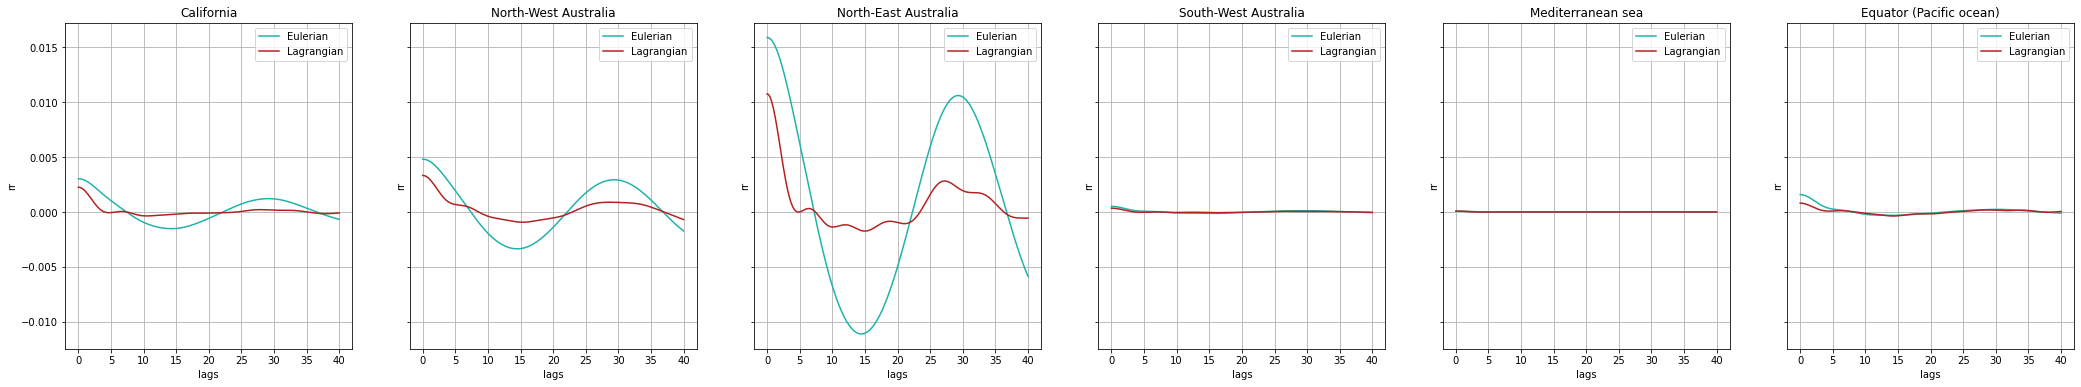

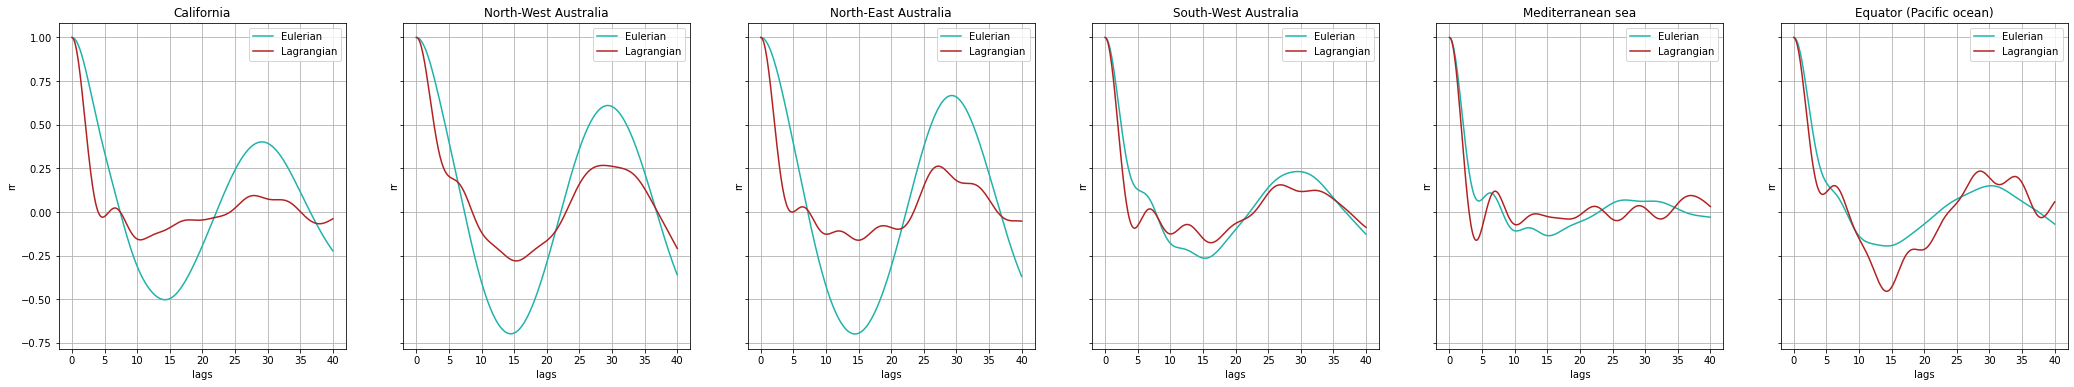

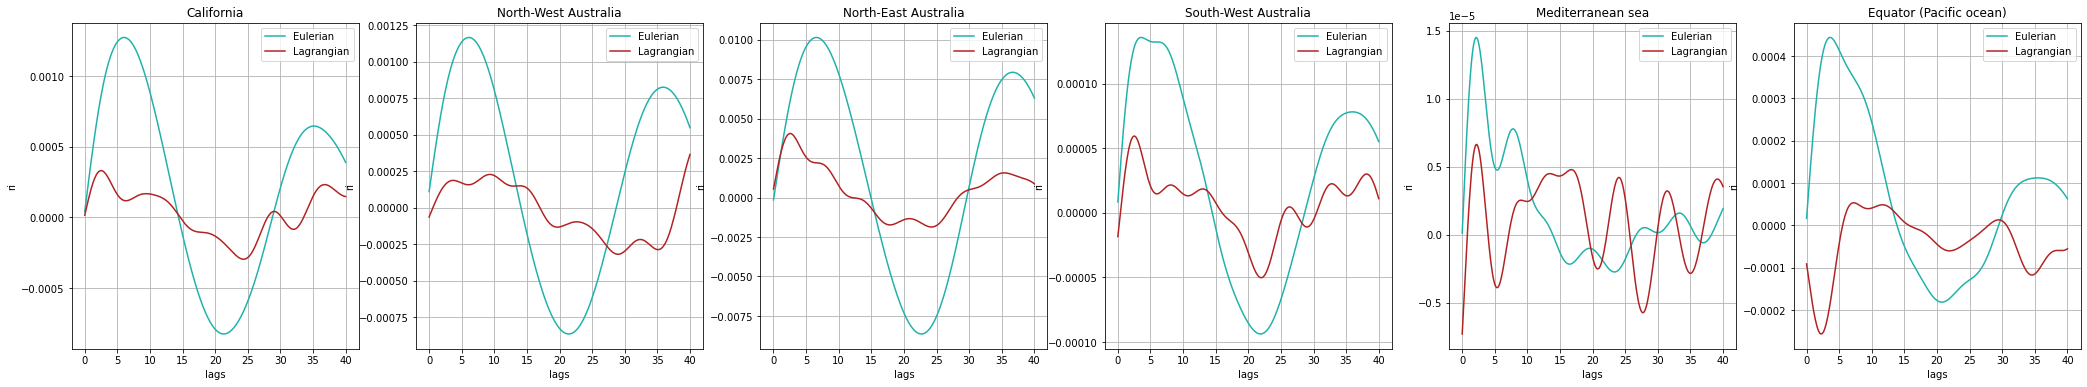

In [64]:
bbox = [bbox_cal,bbox_nwa,bbox_nea,bbox_swa,bbox_med,bbox_eq]
titles = ['California', 'North-West Australia','North-East Australia',
          'South-West Australia','Mediterranean sea','Equator (Pacific ocean)']

fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    dsE.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=True)
for i,title in zip(range(len(bbox)),titles):
    (dsE/dsE.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    (dsL/dsL.isel(lags=0)).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').rr.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend()
    ax[i].set_title(title)
    
fig,ax = plt.subplots(1,len(bbox),figsize=(6*len(bbox),6),sharey=False)
for i,title in zip(range(len(bbox)),titles):
    dsE.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').ri.plot(ax=ax[i],c='lightseagreen',label='Eulerian')
    dsL.sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest').ri.plot(ax=ax[i],c='firebrick',label='Lagrangian')
    ax[i].grid();ax[i].legend();
    ax[i].set_title(title);

#### Estimation of decorrelation timescale

In [43]:
i=2
((dsE/dsE.isel(lags=0))).sel(lat_bins=bbox[i][1],lon_bins=bbox[i][0],method='nearest'
                            ).sel(lags=slice(0,10)).rr.integrate('lags')

<xarray.DataArray 'rr' ()>
array(3.76611845)
Coordinates:
    lon_bins  float64 115.0
    lat_bins  float64 -15.0

#### Bins near area of interest

Text(0.5, 1.0, 'Eulerian')

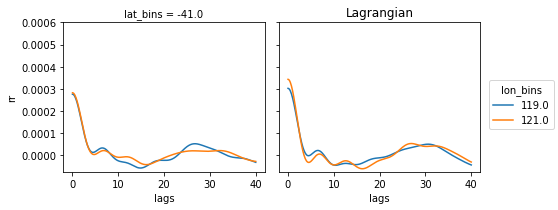

<Figure size 432x288 with 0 Axes>

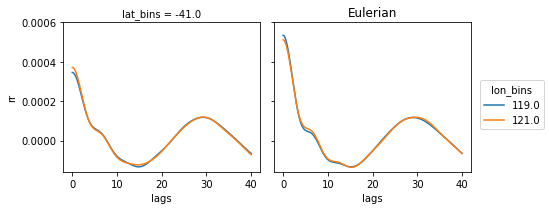

In [78]:
lonlim,latlim = [bbox_swa[0]-2,bbox_swa[0]+2],[bbox_swa[1]-2,bbox_swa[1]+2]

dsL.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(None,6e-4))
plt.title('Lagrangian')
plt.figure()
dsE.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(None,6e-4))
plt.title('Eulerian')

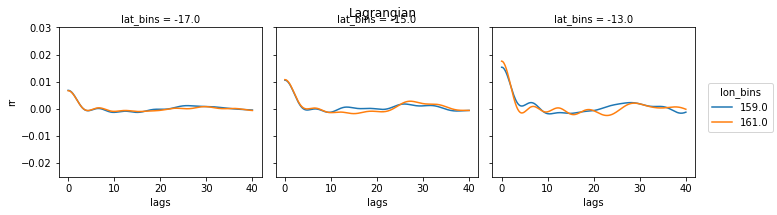

<Figure size 432x288 with 0 Axes>

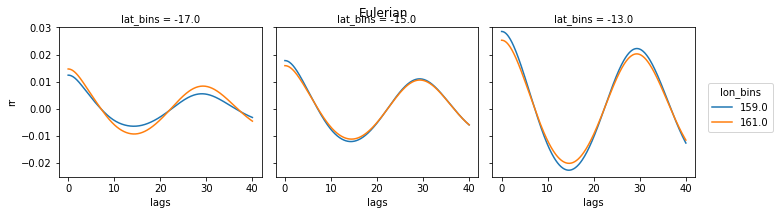

In [90]:
lonlim,latlim = [bbox_nea[0]-2,bbox_nea[0]+2],[bbox_nea[1]-2,bbox_nea[1]+2]

dsL.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(-0.025,30e-3))
plt.suptitle('Lagrangian')
plt.figure()
dsE.sel(lat_bins=slice(latlim[0],latlim[1]),lon_bins=slice(lonlim[0],lonlim[1])
       ).rr.plot(hue='lon_bins',col='lat_bins',ylim=(-0.025,30e-3))
plt.suptitle('Eulerian') 
fig.tight_layout()

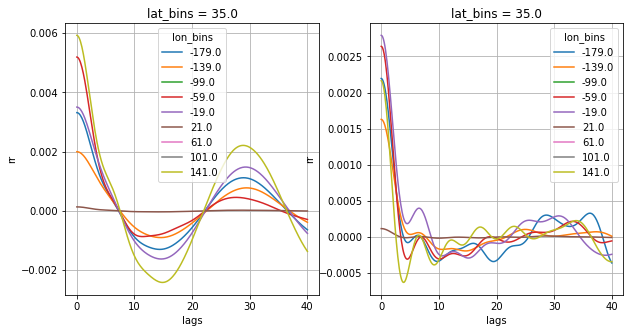

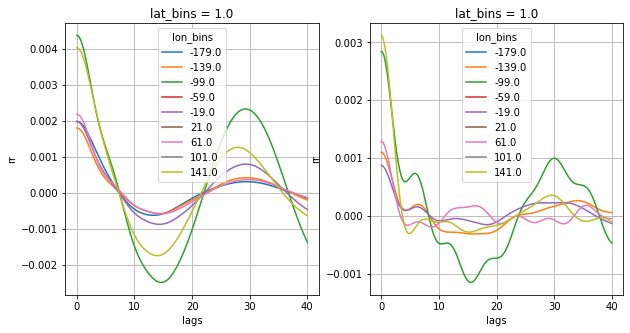

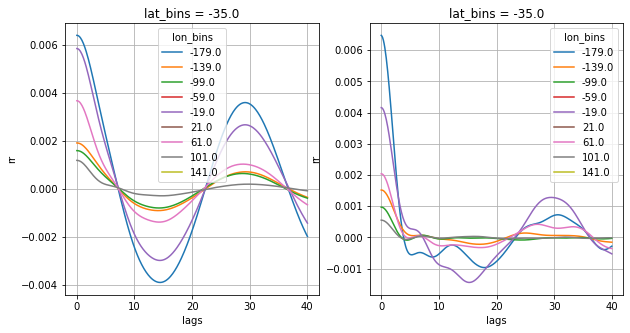

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=-35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=-35,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()

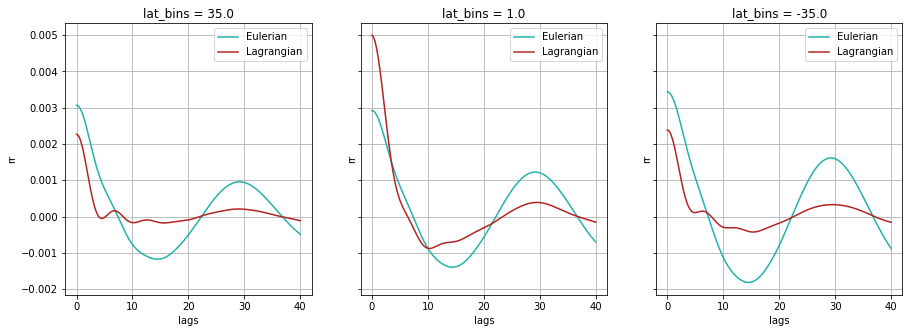

In [24]:
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
dsE.sel(lat_bins=35,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=35,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='firebrick',label='Lagrangian')
axs[0].grid();axs[0].legend()
dsE.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='firebrick',label='Lagrangian')
axs[1].grid();axs[1].legend()
dsE.sel(lat_bins=-35,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=-35,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='firebrick',label='Lagrangian')
axs[2].grid();axs[2].legend()

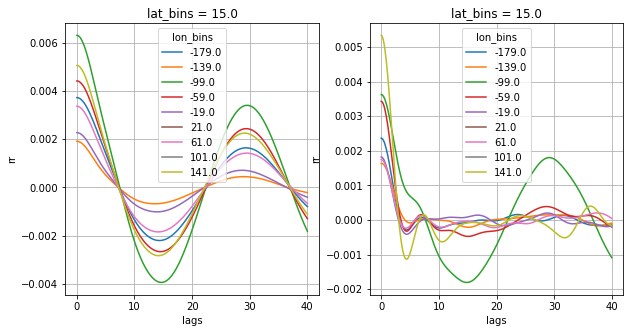

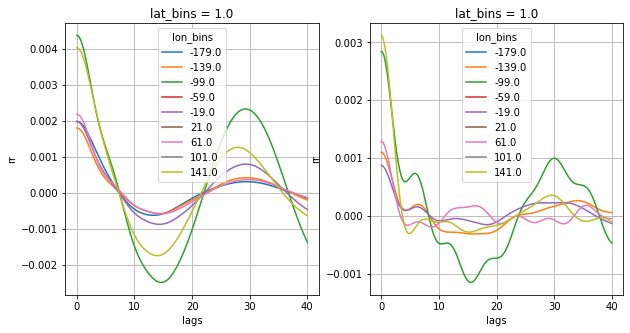

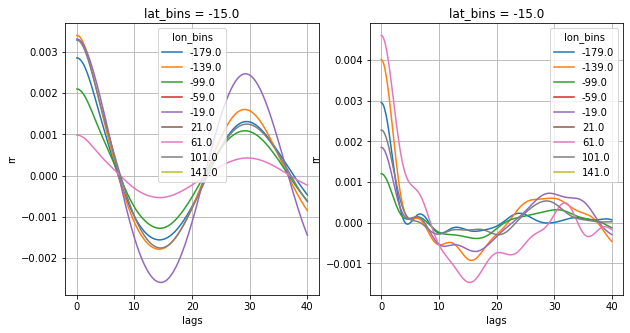

In [25]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=0,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()
fig,axs = plt.subplots(1,2,figsize=(10,5))
dsE.sel(lat_bins=-15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[0])
axs[0].grid()
dsL.sel(lat_bins=-15,method='nearest').rr.isel(lon_bins=slice(0,None,20)).plot(hue='lon_bins',ax=axs[1])
axs[1].grid()

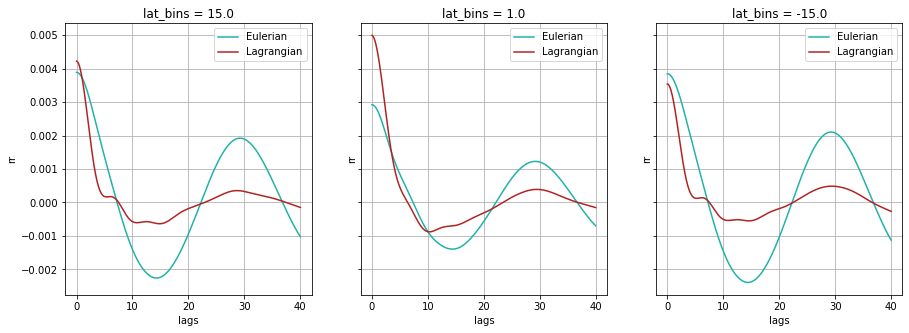

In [26]:
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
dsE.sel(lat_bins=15,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=15,method='nearest').rr.mean('lon_bins').plot(ax=axs[0],c='firebrick',label='Lagrangian')
axs[0].grid();axs[0].legend()
dsE.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=0,method='nearest').rr.mean('lon_bins').plot(ax=axs[1],c='firebrick',label='Lagrangian')
axs[1].grid();axs[1].legend()
dsE.sel(lat_bins=-15,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='lightseagreen',label='Eulerian')
dsL.sel(lat_bins=-15,method='nearest').rr.mean('lon_bins').plot(ax=axs[2],c='firebrick',label='Lagrangian')
axs[2].grid();axs[2].legend()

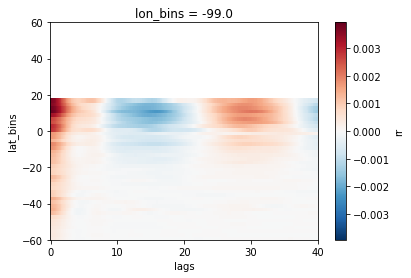

In [48]:
dsL.sel(lon_bins=-99,method='nearest').rr.plot()

Text(0.5, 1.0, 'Lagrangian real-real covariance')

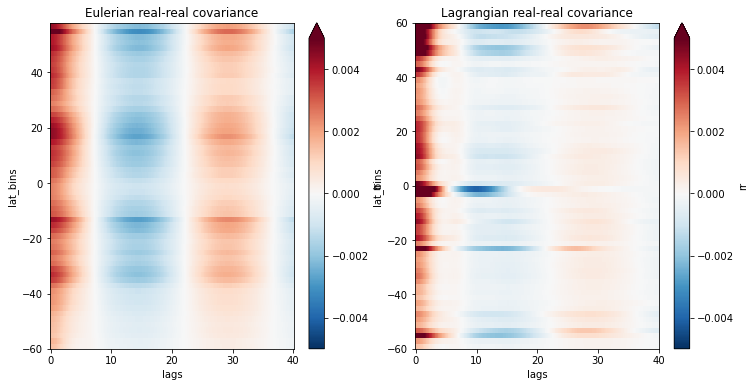

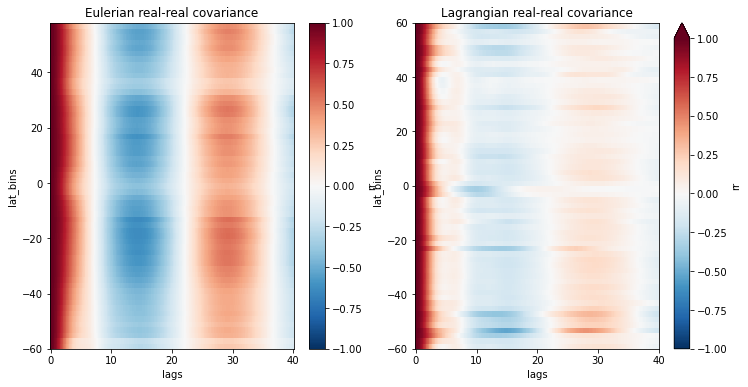

In [7]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[0],vmax=0.005)
dsL.mean('lon_bins').rr.plot(y='lat_bins',ax=axs[1],vmax=0.005)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')


fig,axs = plt.subplots(1,2,figsize=(12,6))
(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[0],vmax=1)
(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.plot(y='lat_bins',ax=axs[1],vmax=1)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')



Text(0.5, 1.0, 'Lagrangian real-real variance')

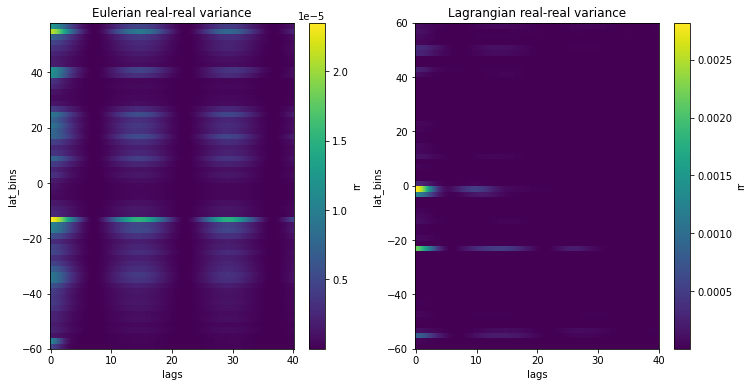

In [9]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
dsE.var('lon_bins').rr.plot(y='lat_bins',ax=axs[0])
dsL.var('lon_bins').rr.plot(y='lat_bins',ax=axs[1])
axs[0].set_title('Eulerian real-real variance')
axs[1].set_title('Lagrangian real-real variance')


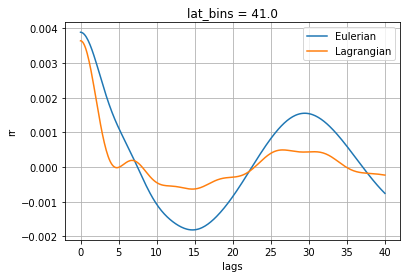

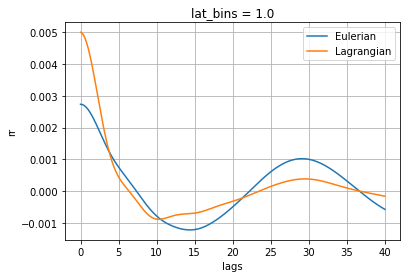

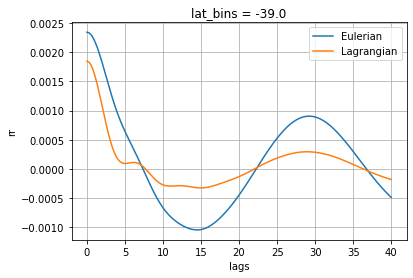

In [11]:
plt.figure()
dsE.mean('lon_bins').sel(lat_bins=40.,method='nearest').Crr.plot(label='Eulerian')
dsL.mean('lon_bins').sel(lat_bins=40.,method='nearest').rr.plot(label='Lagrangian')
plt.grid();plt.legend()

plt.figure()
dsE.mean('lon_bins').sel(lat_bins=.5).Crr.plot(label='Eulerian')
dsL.mean('lon_bins').sel(lat_bins=1.).rr.plot(label='Lagrangian')
plt.grid();plt.legend()

plt.figure()
dsE.mean('lon_bins').sel(lat_bins=-40.,method='nearest').Crr.plot(label='Eulerian')
dsL.mean('lon_bins').sel(lat_bins=-40.,method='nearest').rr.plot(label='Lagrangian')
plt.grid();plt.legend()
#dsL.mean('lon_bins').sel(lat_bins=-1.).rr.plot()

In [31]:
number = dsE.mean('lon_bins').Crr.isel(lat_bins=slice(0,None,10)).lat_bins.size

cmap = plt.get_cmap('bone')
#colors_Ta = [cmap_Ta(i) for i in np.linspace(0.5, 1, number)]
colors = [cmap(i) for i in np.linspace(0., .8, number)]




In [32]:
dsE_sub = dsE.mean('lon_bins').Crr.isel(lat_bins=slice(0,None,10))
dsL_sub = dsL.mean('lon_bins').rr.isel(lat_bins=slice(0,None,10))

(-0.7, 1.1)

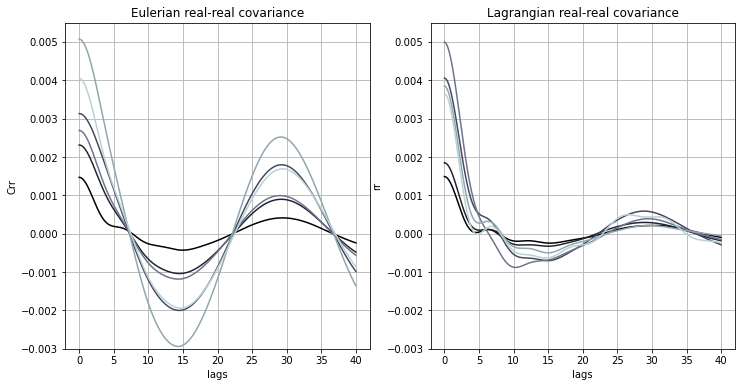

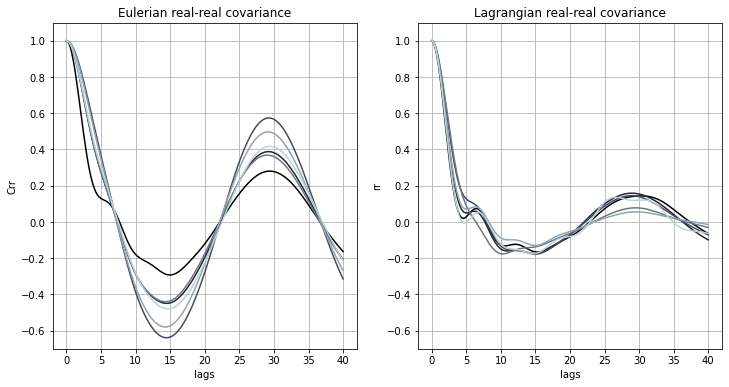

In [33]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for i,c in enumerate(colors):
    dsE_sub.isel(lat_bins=i).plot(ax=axs[0],c=c)
    dsL_sub.isel(lat_bins=i).plot(ax=axs[1],c=c)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid()
axs[0].set_ylim(-0.003,0.0055);axs[1].set_ylim(-0.003,0.0055)

fig,axs = plt.subplots(1,2,figsize=(12,6))
for i,c in enumerate(colors):
    (dsE_sub/dsE_sub.isel(lags=0)).isel(lat_bins=i).plot(ax=axs[0],c=c)
    (dsL_sub/dsL_sub.isel(lags=0)).isel(lat_bins=i).plot(ax=axs[1],c=c)
#(dsE.mean('lon_bins')/dsE.mean('lon_bins').isel(lags=0)).Crr.isel(lat_bins=slice(0,None,10)
#                                                                 ).plot(hue='lat_bins',ax=axs[0],add_legend=False)
#(dsL.mean('lon_bins')/dsL.mean('lon_bins').isel(lags=0)).rr.isel(lat_bins=slice(0,None,10)
#                                                                ).plot(hue='lat_bins',ax=axs[1],add_legend=False)
axs[0].set_title('Eulerian real-real covariance')
axs[1].set_title('Lagrangian real-real covariance')
axs[0].grid();axs[1].grid();axs[0].set_ylim(-0.7,1.1);axs[1].set_ylim(-0.7,1.1)

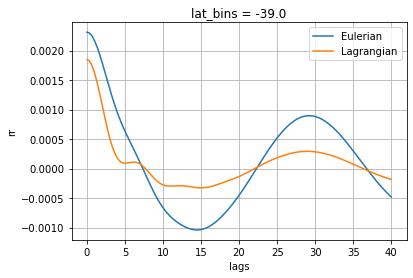

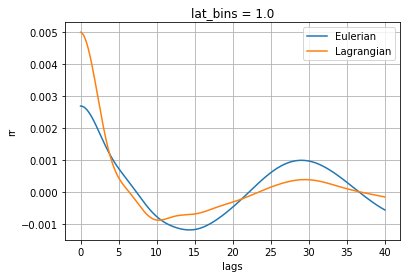

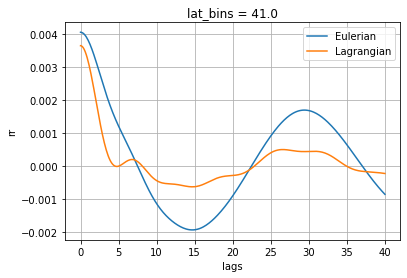

In [44]:
dsE_sub.isel(lat_bins=1).plot(label='Eulerian')
dsL_sub.isel(lat_bins=1).plot(label='Lagrangian')
plt.grid();plt.legend()

plt.figure()
dsE_sub.isel(lat_bins=-3).plot(label='Eulerian')
dsL_sub.isel(lat_bins=-3).plot(label='Lagrangian')
plt.grid();plt.legend()

plt.figure()
dsE_sub.isel(lat_bins=-1).plot(label='Eulerian')
dsL_sub.isel(lat_bins=-1).plot(label='Lagrangian')
plt.grid();plt.legend()